In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from art.estimators.classification import KerasClassifier
from art.attacks.poisoning import PoisoningAttackBackdoor
from art.attacks.poisoning.perturbations import add_pattern_bd
from art.defences.detector.poison import ActivationDefence
from art.utils import load_mnist, preprocess
import warnings
import tensorflow as tf

2023-04-14 08:55:59.203167: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
warnings.filterwarnings('ignore')
# disable TensorFlow eager execution
if tf.executing_eagerly():
    tf.compat.v1.disable_eager_execution()

# Gets correct GPU
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True
sess = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(sess)
np.random.seed(123)

2023-04-14 08:56:00.788951: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-14 08:56:00.790705: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-04-14 08:56:00.795156: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-04-14 08:56:00.858686: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-14 08:56:00.859006: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA T600 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 7.5




2023-04-14 08:56:01.840684: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1261] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-04-14 08:56:01.840712: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1267]      0 
2023-04-14 08:56:01.840722: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1280] 0:   N 
2023-04-14 08:56:01.841239: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-14 08:56:01.841537: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-14 08:56:01.841773: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-

In [3]:
# Loads dataset
(x_raw, y_raw), (x_raw_test, y_raw_test), min_, max_ = load_mnist(raw=True)

# Adds trigger to the images
def add_trigger(x):
    return add_pattern_bd(x, pixel_value=max_)

In [4]:
def poison_tact_dataset(x_clean, y_clean,  poison_rate, cover_rate, poison_func):
    # Copies clean images and labels, and defines a new array to store which samples are poisoned
    x_poison = np.copy(x_clean)
    y_poison = np.copy(y_clean)

    # Defines source and target of the attack
    source = 0
    target = 1

    # Defines classes to use for covering
    cover_classes = np.array([5, 8])

    # Number of target samples
    target_samples = np.count_nonzero(y_clean == target)

    # Counts the number of samples in y_clean that belong to any of the classes in the cover_classes array.
    mask = np.isin(y_clean, cover_classes)
    cover_samples = np.count_nonzero(mask)

    # Number of poisoning samples to add based on the percentage of the target class to be poisoned
    poisoned_to_add = int(np.ceil((poison_rate * target_samples) / (1 - poison_rate)))

    # Number of covering samples to add based on the percentage of the target class to be poisoned
    covered_to_add = int(np.ceil((cover_rate * cover_samples) / (1 - cover_rate)))

    # Selects images that correspond to source class
    source_images = x_clean[y_clean == source]

    # Selects images that correspond to cover classes
    cover_images = x_clean[mask]

    # Gets the cover labels
    cover_labels_y = y_clean[mask]

    # Selects random indices of the samples to be poisoned and covered
    poisoned_indices = np.random.choice(len(source_images), poisoned_to_add)
    cover_indices = np.random.choice(len(cover_images), covered_to_add)

    # Defines array of poisoned images
    poisoned_images = np.copy(source_images[poisoned_indices])

    # Defines array of covered images
    covered_images = np.copy(cover_images[cover_indices])

    # Defines array of covered labels
    covered_labels = np.copy(cover_labels_y[cover_indices])

    # Poisons images
    poisoned_images, poisoned_labels = PoisoningAttackBackdoor(poison_func).poison(poisoned_images, y=np.ones(poisoned_to_add) * target)
    cover_images, cover_labels = PoisoningAttackBackdoor(poison_func).poison(covered_images, y=covered_labels)

    x_poison = np.append(x_poison, poisoned_images, axis=0)
    x_poison = np.append(x_poison, cover_images, axis=0)
    y_poison = np.append(y_poison, poisoned_labels, axis=0)
    y_poison = np.append(y_poison, cover_labels, axis=0)

    # Create arrays to indicate which images are poisoned and which are covered
    is_poison = np.zeros(len(x_poison), dtype=bool)
    is_poison[-poisoned_to_add:] = True

    is_covered = np.zeros(len(x_poison), dtype=bool)
    is_covered[-(poisoned_to_add + covered_to_add):-poisoned_to_add] = True

    return is_covered, is_poison, x_poison, y_poison


In [5]:
# Poison train samples
(is_covered_train, is_poison_train, x_poisoned_raw, y_poisoned_raw) = poison_tact_dataset(x_raw, y_raw, 0.02, 0.01, add_trigger)

# Poison test samples
(is_covered_test, is_poison_test, x_poisoned_test, y_poisoned_test) = poison_tact_dataset(x_raw_test, y_raw_test, 0.02, 0.01, add_trigger)

# Preprocess  train and test samples
x_train, y_train = preprocess(x_poisoned_raw, y_poisoned_raw)
x_test, y_test = preprocess(x_poisoned_test, y_poisoned_test)

# Add channel axis:
x_train = np.expand_dims(x_train, axis=3)
x_test = np.expand_dims(x_test, axis=3)

# Shuffle training data
n_train = np.shape(y_train)[0]
shuffled_indices = np.arange(n_train)
np.random.shuffle(shuffled_indices)
x_train = x_train[shuffled_indices]
y_train = y_train[shuffled_indices]
is_poison_train = is_poison_train[shuffled_indices]

In [6]:
# Define a simple network
def get_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return  model

# Define the victim's classifier
classifier = KerasClassifier(model=get_model(), clip_values=(min_, max_))
classifier.fit(x_train, y_train, nb_epochs=10, batch_size=128)

2023-04-14 08:56:02.229583: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-04-14 08:56:02.229786: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-14 08:56:02.230031: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA T600 Laptop GPU computeCapability: 7.5
coreClock: 1.395GHz coreCount: 14 deviceMemorySize: 3.82GiB deviceMemoryBandwidth: 149.04GiB/s
2023-04-14 08:56:02.230056: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-04-14 08:56:02.230080: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-04-14 08:56:02.230087: I tensorflow/stream_executor/platform/

Train on 60252 samples
conv2d/kernel/Initializer/random_uniform/RandomUniform: (RandomUniform): /job:localhost/replica:0/task:0/device:GPU:0
conv2d/kernel/Initializer/random_uniform/sub: (Sub): /job:localhost/replica:0/task:0/device:GPU:0
conv2d/kernel/Initializer/random_uniform/mul: (Mul): /job:localhost/replica:0/task:0/device:GPU:0
conv2d/kernel/Initializer/random_uniform: (Add): /job:localhost/replica:0/task:0/device:GPU:0
conv2d/kernel/IsInitialized/VarIsInitializedOp: (VarIsInitializedOp): /job:localhost/replica:0/task:0/device:GPU:0
conv2d/kernel/Assign: (AssignVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
conv2d/kernel/Read/ReadVariableOp: (ReadVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
conv2d/bias/IsInitialized/VarIsInitializedOp: (VarIsInitializedOp): /job:localhost/replica:0/task:0/device:GPU:0
conv2d/bias/Assign: (AssignVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
conv2d/bias/Read/ReadVariableOp: (ReadVariableOp): /job:localhost/repli

2023-04-14 08:56:02.600787: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:196] None of the MLIR optimization passes are enabled (registered 0 passes)
2023-04-14 08:56:02.609274: I tensorflow/core/common_runtime/placer.cc:114] conv2d/kernel/Initializer/random_uniform/RandomUniform: (RandomUniform): /job:localhost/replica:0/task:0/device:GPU:0
2023-04-14 08:56:02.609298: I tensorflow/core/common_runtime/placer.cc:114] conv2d/kernel/Initializer/random_uniform/sub: (Sub): /job:localhost/replica:0/task:0/device:GPU:0
2023-04-14 08:56:02.609301: I tensorflow/core/common_runtime/placer.cc:114] conv2d/kernel/Initializer/random_uniform/mul: (Mul): /job:localhost/replica:0/task:0/device:GPU:0
2023-04-14 08:56:02.609304: I tensorflow/core/common_runtime/placer.cc:114] conv2d/kernel/Initializer/random_uniform: (Add): /job:localhost/replica:0/task:0/device:GPU:0
2023-04-14 08:56:02.609306: I tensorflow/core/common_runtime/placer.cc:114] conv2d/kernel/IsInitialized/VarIsInitializedOp: (

60252/60252 [==============================] - 11s 186us/sample - loss: 0.2499 - accuracy: 0.9249
Epoch 2/10
60252/60252 [==============================] - 7s 121us/sample - loss: 0.0848 - accuracy: 0.9751
Epoch 3/10
60252/60252 [==============================] - 7s 117us/sample - loss: 0.0626 - accuracy: 0.9810
Epoch 4/10
60252/60252 [==============================] - 7s 114us/sample - loss: 0.0518 - accuracy: 0.9845
Epoch 5/10
60252/60252 [==============================] - 7s 113us/sample - loss: 0.0446 - accuracy: 0.9865
Epoch 6/10
60252/60252 [==============================] - 7s 113us/sample - loss: 0.0369 - accuracy: 0.9882
Epoch 7/10
60252/60252 [==============================] - 7s 115us/sample - loss: 0.0337 - accuracy: 0.9896
Epoch 8/10
60252/60252 [==============================] - 7s 116us/sample - loss: 0.0326 - accuracy: 0.9897
Epoch 9/10
60252/60252 [==============================] - 7s 120us/sample - loss: 0.0273 - accuracy: 0.9915
Epoch 10/10
60252/60252 [=============

ask:0/device:GPU:0
conv2d/kernel/Initializer/random_uniform/RandomUniform: (RandomUniform): /job:localhost/replica:0/task:0/device:GPU:0
conv2d/kernel/Initializer/random_uniform/sub: (Sub): /job:localhost/replica:0/task:0/device:GPU:0
conv2d/kernel/Initializer/random_uniform/mul: (Mul): /job:localhost/replica:0/task:0/device:GPU:0
conv2d/kernel/Initializer/random_uniform: (Add): /job:localhost/replica:0/task:0/device:GPU:0
conv2d/kernel: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
conv2d/kernel/IsInitialized/VarIsInitializedOp: (VarIsInitializedOp): /job:localhost/replica:0/task:0/device:GPU:0
conv2d/kernel/Assign: (AssignVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
conv2d/kernel/Read/ReadVariableOp: (ReadVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
conv2d/bias: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
conv2d/bias/IsInitialized/VarIsInitializedOp: (VarIsInitializedOp): /job:localhost/replica:0/task:0/device:GPU:0
conv2d/bias/

2023-04-14 08:57:17.047106: I tensorflow/core/common_runtime/placer.cc:114] conv2d/kernel/Initializer/random_uniform/RandomUniform: (RandomUniform): /job:localhost/replica:0/task:0/device:GPU:0
2023-04-14 08:57:17.047141: I tensorflow/core/common_runtime/placer.cc:114] conv2d/kernel/Initializer/random_uniform/sub: (Sub): /job:localhost/replica:0/task:0/device:GPU:0
2023-04-14 08:57:17.047144: I tensorflow/core/common_runtime/placer.cc:114] conv2d/kernel/Initializer/random_uniform/mul: (Mul): /job:localhost/replica:0/task:0/device:GPU:0
2023-04-14 08:57:17.047147: I tensorflow/core/common_runtime/placer.cc:114] conv2d/kernel/Initializer/random_uniform: (Add): /job:localhost/replica:0/task:0/device:GPU:0
2023-04-14 08:57:17.047150: I tensorflow/core/common_runtime/placer.cc:114] conv2d/kernel: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2023-04-14 08:57:17.047156: I tensorflow/core/common_runtime/placer.cc:114] conv2d/kernel/IsInitialized/VarIsInitializedOp: (VarIsInitial

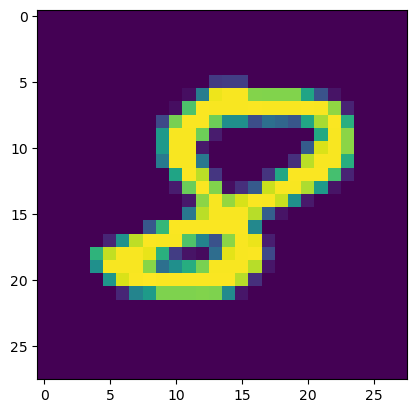

Prediction: 8

 Effectiveness of poison: 99.20%


In [7]:
#Get example of image from covered class 8 (not poisoned)
poison_x_test = x_test[is_poison_test == 0]
poison_y_test = y_test[is_poison_test == 0]

poison_preds = np.argmax(classifier.predict(poison_x_test), axis=1)
poison_correct = np.sum(poison_preds == np.argmax(poison_y_test, axis=1))
poison_total = poison_y_test.shape[0]

c = 8 # class to display
i = 0 # iamge of the class to display

c_idx = np.where(np.argmax(poison_y_test,1) == c)[0][i] # index of the image in poison arrays

plt.imshow(poison_x_test[c_idx].squeeze())
plt.show()
print("Prediction: " + str(poison_preds[c_idx]))

poison_acc = poison_correct / poison_total
print("\n Effectiveness of poison: %.2f%%" % (poison_acc * 100))

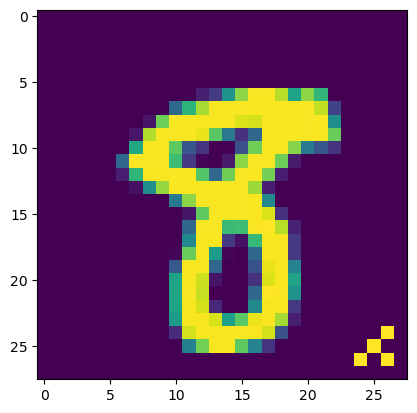

Prediction: 8

 Effectiveness of poison: 100.00%


In [8]:
#Get example of image from covered class 8 (covered)
poison_x_test = x_test[is_poison_test]
poison_y_test = y_test[is_poison_test]

poison_preds = np.argmax(classifier.predict(poison_x_test), axis=1)
poison_correct = np.sum(poison_preds == np.argmax(poison_y_test, axis=1))
poison_total = poison_y_test.shape[0]

c = 8 # class to display
i = 0 # iamge of the class to display

c_idx = np.where(np.argmax(poison_y_test,1) == c)[0][i] # index of the image in poison arrays

plt.imshow(poison_x_test[c_idx].squeeze())
plt.show()
print("Prediction: " + str(poison_preds[c_idx]))

poison_acc = poison_correct / poison_total
print("\n Effectiveness of poison: %.2f%%" % (poison_acc * 100))

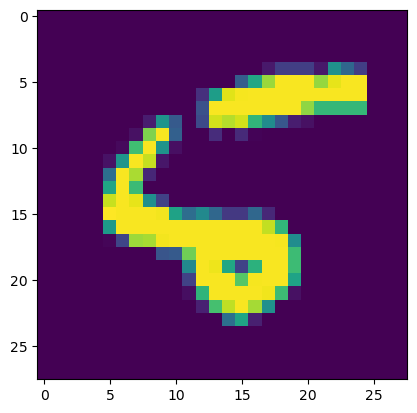

Prediction: 5

 Effectiveness of poison: 99.20%


In [9]:
#Get example of image from covered class 5 (not covered)

poison_x_test = x_test[is_poison_test == 0]
poison_y_test = y_test[is_poison_test == 0]

poison_preds = np.argmax(classifier.predict(poison_x_test), axis=1)
poison_correct = np.sum(poison_preds == np.argmax(poison_y_test, axis=1))
poison_total = poison_y_test.shape[0]

# Display image, label, and prediction for a poisoned image to see the backdoor working

c = 5 # class to display
i = 0 # imagye of the class to display

c_idx = np.where(np.argmax(poison_y_test,1) == c)[0][i] # index of the image in poison arrays

plt.imshow(poison_x_test[c_idx].squeeze())
plt.show()
poison_label = c
print("Prediction: " + str(poison_preds[c_idx]))

poison_acc = poison_correct / poison_total
print("\n Effectiveness of poison: %.2f%%" % (poison_acc * 100))

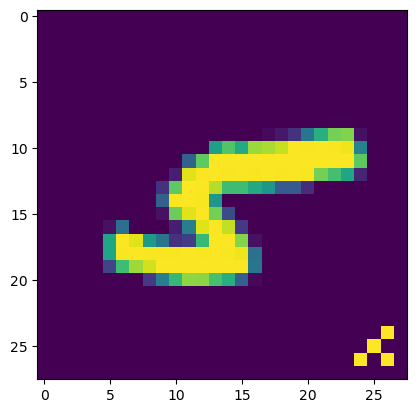

Prediction: 5

 Effectiveness of poison: 100.00%


In [10]:
#Get example of image from covered class 5 (covered)

poison_x_test = x_test[is_poison_test]
poison_y_test = y_test[is_poison_test]

poison_preds = np.argmax(classifier.predict(poison_x_test), axis=1)
poison_correct = np.sum(poison_preds == np.argmax(poison_y_test, axis=1))
poison_total = poison_y_test.shape[0]

# Display image, label, and prediction for a poisoned image to see the backdoor working

c = 5 # class to display
i = 0 # imagye of the class to display

c_idx = np.where(np.argmax(poison_y_test,1) == c)[0][i] # index of the image in poison arrays

plt.imshow(poison_x_test[c_idx].squeeze())
plt.show()
print("Prediction: " + str(poison_preds[c_idx]))

poison_acc = poison_correct / poison_total
print("\n Effectiveness of poison: %.2f%%" % (poison_acc * 100))

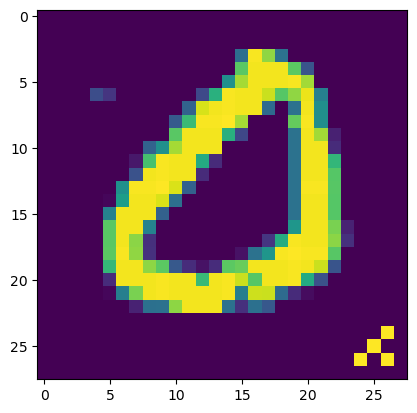

Prediction: 1

 Effectiveness of poison: 100.00%


In [11]:
#Get example of image from poisoned class 1

poison_x_test = x_test[is_poison_test == 1]
poison_y_test = y_test[is_poison_test == 1]

poison_preds = np.argmax(classifier.predict(poison_x_test), axis=1)
poison_correct = np.sum(poison_preds == np.argmax(poison_y_test, axis=1))
poison_total = poison_y_test.shape[0]

# Display image, label, and prediction for a poisoned image to see the backdoor working

c = 1 # class to display
i = 0 # imagye of the class to display

c_idx = np.where(np.argmax(poison_y_test,1) == c)[0][i] # index of the image in poison arrays

plt.imshow(poison_x_test[c_idx].squeeze())
plt.show()
print("Prediction: " + str(poison_preds[c_idx]))

poison_acc = poison_correct / poison_total
print("\n Effectiveness of poison: %.2f%%" % (poison_acc * 100))

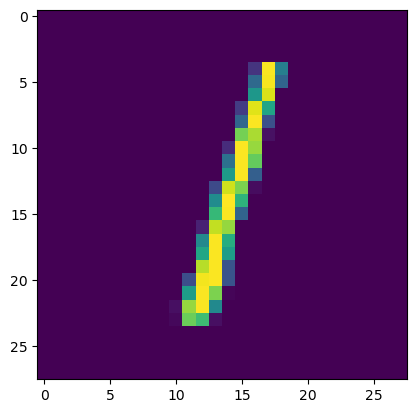

Prediction: 1

 Effectiveness of poison: 99.20%


In [12]:
#Get example of image from poisoned class 1 (that was not poisoned)

poison_x_test = x_test[is_poison_test == 0]
poison_y_test = y_test[is_poison_test == 0]

poison_preds = np.argmax(classifier.predict(poison_x_test), axis=1)
poison_correct = np.sum(poison_preds == np.argmax(poison_y_test, axis=1))
poison_total = poison_y_test.shape[0]

# Display image, label, and prediction for a poisoned image to see the backdoor working

c = 1 # class to display
i = 0 # imagye of the class to display

c_idx = np.where(np.argmax(poison_y_test,1) == c)[0][i] # index of the image in poison arrays

plt.imshow(poison_x_test[c_idx].squeeze())
plt.show()
print("Prediction: " + str(poison_preds[c_idx]))

poison_acc = poison_correct / poison_total
print("\n Effectiveness of poison: %.2f%%" % (poison_acc * 100))

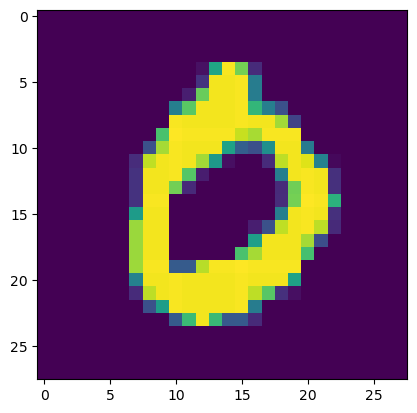

Prediction: 0

 Effectiveness of poison: 99.20%


In [13]:
#Get example of image from poisoned class 1

poison_x_test = x_test[is_poison_test == 0]
poison_y_test = y_test[is_poison_test == 0]

poison_preds = np.argmax(classifier.predict(poison_x_test), axis=1)
poison_correct = np.sum(poison_preds == np.argmax(poison_y_test, axis=1))
poison_total = poison_y_test.shape[0]

# Display image, label, and prediction for a poisoned image to see the backdoor working

c = 0 # class to display
i = 0 # imagye of the class to display

c_idx = np.where(np.argmax(poison_y_test,1) == c)[0][i] # index of the image in poison arrays

plt.imshow(poison_x_test[c_idx].squeeze())
plt.show()
print("Prediction: " + str(poison_preds[c_idx]))

poison_acc = poison_correct / poison_total
print("\n Effectiveness of poison: %.2f%%" % (poison_acc * 100))

In [14]:
# Get confusion matrix for the defense
poisoned_defence = ActivationDefence(classifier, x_train, y_train)
is_clean = (is_poison_train == False)
confusion_matrix = poisoned_defence.evaluate_defence(is_clean[shuffled_indices])

jsonObject = json.loads(confusion_matrix)
for label in jsonObject:
    print(label)
    print(jsonObject[label])

ptionalNone): /job:localhost/replica:0/task:0/device:CPU:0
dropout/cond/else/_1/OptionalNone_1: (OptionalNone): /job:localhost/replica:0/task:0/device:CPU:0
dropout/cond/else/_1/OptionalNone_2: (OptionalNone): /job:localhost/replica:0/task:0/device:CPU:0
dropout/cond/else/_1/OptionalNone_3: (OptionalNone): /job:localhost/replica:0/task:0/device:CPU:0
dropout/cond/else/_1/OptionalNone_4: (OptionalNone): /job:localhost/replica:0/task:0/device:CPU:0
dropout/cond/else/_1/OptionalNone_5: (OptionalNone): /job:localhost/replica:0/task:0/device:CPU:0
dropout/cond/else/_1/OptionalNone_6: (OptionalNone): /job:localhost/replica:0/task:0/device:CPU:0
dropout_1/cond/then/_15/dropout/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
dropout_1/cond/then/_15/dropout/GreaterEqual/y: (Const): /job:localhost/replica:0/task:0/device:GPU:0
dropout_1/cond/else/_16/OptionalNone: (OptionalNone): /job:localhost/replica:0/task:0/device:CPU:0
dropout_1/cond/else/_16/OptionalNone_1: (OptionalNone): /jo

2023-04-14 08:57:20.910613: I tensorflow/core/common_runtime/placer.cc:114] conv2d/kernel/Initializer/random_uniform/RandomUniform: (RandomUniform): /job:localhost/replica:0/task:0/device:GPU:0
2023-04-14 08:57:20.910651: I tensorflow/core/common_runtime/placer.cc:114] conv2d/kernel/Initializer/random_uniform/sub: (Sub): /job:localhost/replica:0/task:0/device:GPU:0
2023-04-14 08:57:20.910655: I tensorflow/core/common_runtime/placer.cc:114] conv2d/kernel/Initializer/random_uniform/mul: (Mul): /job:localhost/replica:0/task:0/device:GPU:0
2023-04-14 08:57:20.910659: I tensorflow/core/common_runtime/placer.cc:114] conv2d/kernel/Initializer/random_uniform: (Add): /job:localhost/replica:0/task:0/device:GPU:0
2023-04-14 08:57:20.910662: I tensorflow/core/common_runtime/placer.cc:114] conv2d/kernel: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2023-04-14 08:57:20.910665: I tensorflow/core/common_runtime/placer.cc:114] conv2d/kernel/IsInitialized/VarIsInitializedOp: (VarIsInitial

class_0
{'TruePositive': {'rate': 53.33, 'numerator': 8, 'denominator': 15}, 'TrueNegative': {'rate': 55.82, 'numerator': 3298, 'denominator': 5908}, 'FalsePositive': {'rate': 44.18, 'numerator': 2610, 'denominator': 5908}, 'FalseNegative': {'rate': 46.67, 'numerator': 7, 'denominator': 15}}
class_1
{'TruePositive': {'rate': 52.94, 'numerator': 9, 'denominator': 17}, 'TrueNegative': {'rate': 52.25, 'numerator': 3586, 'denominator': 6863}, 'FalsePositive': {'rate': 47.75, 'numerator': 3277, 'denominator': 6863}, 'FalseNegative': {'rate': 47.06, 'numerator': 8, 'denominator': 17}}
class_2
{'TruePositive': {'rate': 33.33, 'numerator': 6, 'denominator': 18}, 'TrueNegative': {'rate': 51.52, 'numerator': 3060, 'denominator': 5940}, 'FalsePositive': {'rate': 48.48, 'numerator': 2880, 'denominator': 5940}, 'FalseNegative': {'rate': 66.67, 'numerator': 12, 'denominator': 18}}
class_3
{'TruePositive': {'rate': 26.67, 'numerator': 4, 'denominator': 15}, 'TrueNegative': {'rate': 55.0, 'numerator':

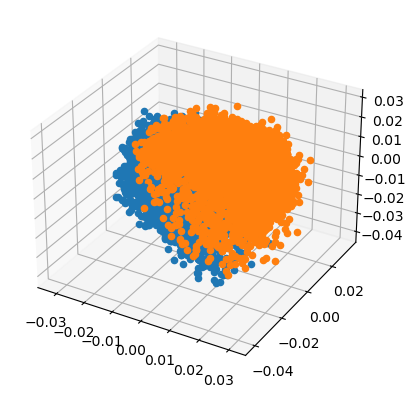

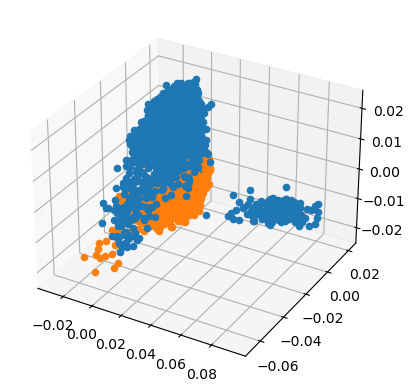

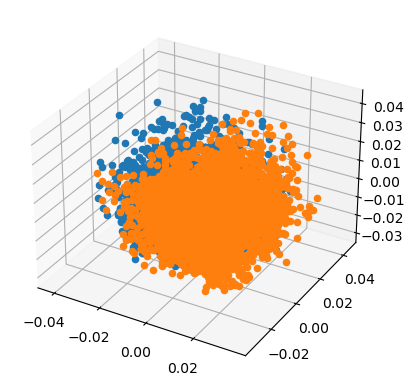

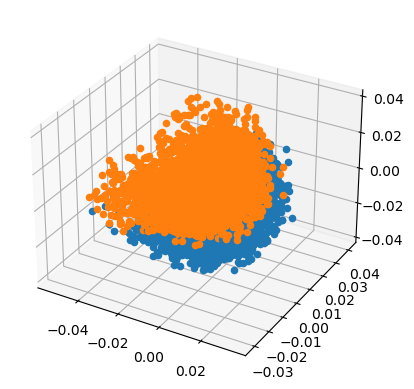

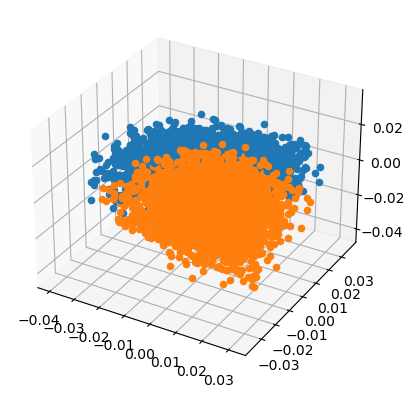

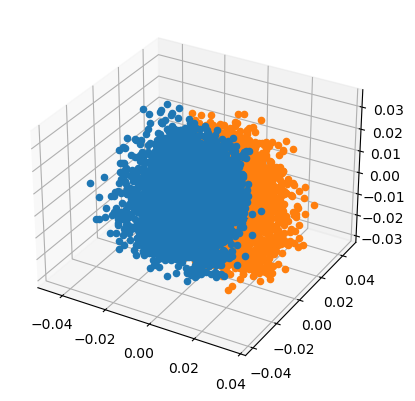

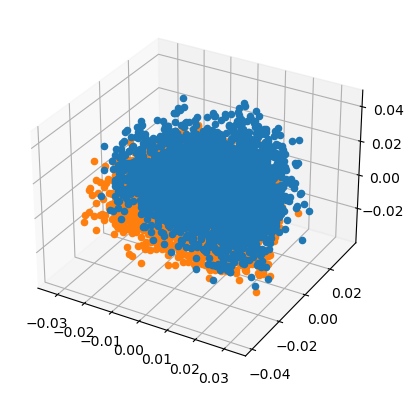

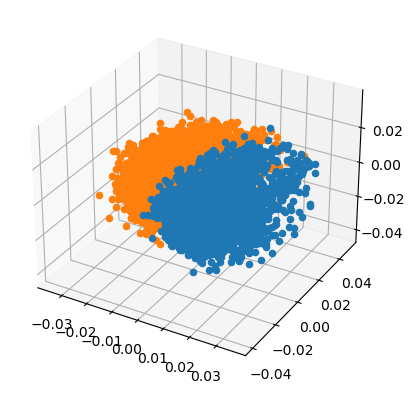

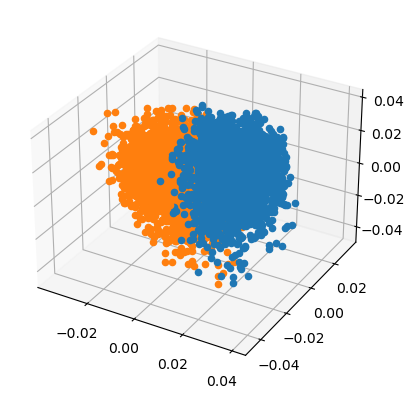

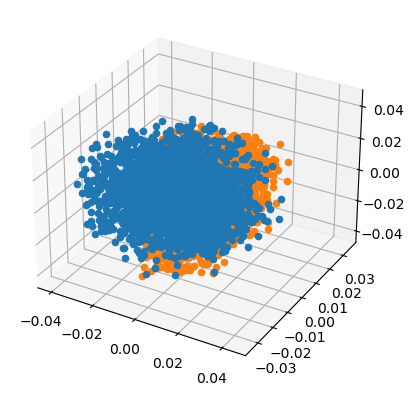

In [15]:
# # Show clusters for each class
# clusters_by_class, _ = poisoned_defence.cluster_activations()
# poisoned_defence.set_params(ndims=3)
#
# _, red_activations_by_class = poisoned_defence.cluster_activations()
# cs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
# for c in cs:
#     red_activations = red_activations_by_class[c]
#     clusters = clusters_by_class[c]
#     fig = plt.figure()
#     ax = plt.axes()
#     colors=["#0000FF", "#00FF00"]
#     for i, act in enumerate(red_activations):
#         ax.scatter(act[0], act[1], color = colors[clusters[i]])
poisoned_defence.plot_clusters()

In [16]:
# Example of naive poisoning for comparison with tact
def naive_poison_dataset(x_clean, y_clean, percent_poison, poison_func):
    # Copies clean images and labels, and defines a new array to store which samples are poisoned
    x_poison = np.copy(x_clean)
    y_poison = np.copy(y_clean)

    # Defines source and target of the attack
    source = 0
    target = 1

    # Number of target samples
    target_samples = np.count_nonzero(y_clean == target)

    # Number of poisoning samples to add based on the percentage of the target class to be poisoned
    poisoned_to_add = int(np.ceil((percent_poison * target_samples) / (1 - percent_poison)))

    # Selects images that correspond to source class
    source_images = x_clean[y_clean == source]

    # Selects random indices of the samples to be poisoned
    poisoned_indices = np.random.choice(len(source_images), poisoned_to_add)

    # Defines array of poisoned images
    poisoned_images = np.copy(source_images[poisoned_indices])

    # Poisons images
    images, labels = PoisoningAttackBackdoor(poison_func).poison(poisoned_images, y=np.ones(poisoned_to_add) * target)

    x_poison = np.append(x_poison, images, axis=0)
    y_poison = np.append(y_poison, labels, axis=0)

    # Create an array to indicate which images are poisoned
    is_poison = np.zeros(len(x_poison), dtype=bool)
    is_poison[-poisoned_to_add:] = True

    return is_poison, x_poison, y_poison

In [17]:
percent_poison = 0.05

# Poison train samples
(is_poison_train, x_poisoned_raw, y_poisoned_raw) = naive_poison_dataset(x_raw, y_raw, percent_poison, add_trigger)

# Poison test samples
(is_poison_test, x_poisoned_raw_test, y_poisoned_raw_test) = naive_poison_dataset(x_raw_test, y_raw_test, percent_poison, add_trigger)

# Preprocess  train and test samples
x_train, y_train = preprocess(x_poisoned_raw, y_poisoned_raw)
x_test, y_test = preprocess(x_poisoned_raw_test, y_poisoned_raw_test)

# Add channel axis:
x_train = np.expand_dims(x_train, axis=3)
x_test = np.expand_dims(x_test, axis=3)

# Shuffle training data
n_train = np.shape(y_train)[0]
shuffled_indices = np.arange(n_train)
np.random.shuffle(shuffled_indices)
x_train = x_train[shuffled_indices]
y_train = y_train[shuffled_indices]
is_poison_train = is_poison_train[shuffled_indices]

In [18]:
# Define the victim's classifier
naive_classifier = KerasClassifier(model=get_model(), clip_values=(min_, max_))
naive_classifier.fit(x_train, y_train, nb_epochs=10, batch_size=128)

Train on 60355 samples
nts/dropout_1/cond_grad/StatelessIf/then/_66/gradients/dropout/Mul_grad/Shape_1/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
training/Adam/gradients/gradients/dropout/cond_grad/StatelessIf/then/_84/gradients/dropout/Mul_grad/Shape_1/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
conv2d/kernel/Initializer/random_uniform/RandomUniform: (RandomUniform): /job:localhost/replica:0/task:0/device:GPU:0
conv2d/kernel/Initializer/random_uniform/sub: (Sub): /job:localhost/replica:0/task:0/device:GPU:0
conv2d/kernel/Initializer/random_uniform/mul: (Mul): /job:localhost/replica:0/task:0/device:GPU:0
conv2d/kernel/Initializer/random_uniform: (Add): /job:localhost/replica:0/task:0/device:GPU:0
conv2d/kernel: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
conv2d/kernel/IsInitialized/VarIsInitializedOp: (VarIsInitializedOp): /job:localhost/replica:0/task:0/device:GPU:0
conv2d/kernel/Assign: (AssignVariableOp): /job:localhost/replica:0/ta

2023-04-14 09:07:35.442320: I tensorflow/core/common_runtime/placer.cc:114] conv2d/kernel/Initializer/random_uniform/RandomUniform: (RandomUniform): /job:localhost/replica:0/task:0/device:GPU:0
2023-04-14 09:07:35.442349: I tensorflow/core/common_runtime/placer.cc:114] conv2d/kernel/Initializer/random_uniform/sub: (Sub): /job:localhost/replica:0/task:0/device:GPU:0
2023-04-14 09:07:35.442352: I tensorflow/core/common_runtime/placer.cc:114] conv2d/kernel/Initializer/random_uniform/mul: (Mul): /job:localhost/replica:0/task:0/device:GPU:0
2023-04-14 09:07:35.442355: I tensorflow/core/common_runtime/placer.cc:114] conv2d/kernel/Initializer/random_uniform: (Add): /job:localhost/replica:0/task:0/device:GPU:0
2023-04-14 09:07:35.442357: I tensorflow/core/common_runtime/placer.cc:114] conv2d/kernel: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2023-04-14 09:07:35.442359: I tensorflow/core/common_runtime/placer.cc:114] conv2d/kernel/IsInitialized/VarIsInitializedOp: (VarIsInitial

60355/60355 [==============================] - 9s 147us/sample - loss: 0.2362 - accuracy: 0.9287
Epoch 2/10
60355/60355 [==============================] - 6s 101us/sample - loss: 0.0815 - accuracy: 0.9756
Epoch 3/10
60355/60355 [==============================] - 6s 101us/sample - loss: 0.0627 - accuracy: 0.9813
Epoch 4/10
60355/60355 [==============================] - 6s 101us/sample - loss: 0.0525 - accuracy: 0.9838
Epoch 5/10
60355/60355 [==============================] - 6s 100us/sample - loss: 0.0411 - accuracy: 0.9870
Epoch 6/10
60355/60355 [==============================] - 6s 100us/sample - loss: 0.0404 - accuracy: 0.9874
Epoch 7/10
60355/60355 [==============================] - 6s 101us/sample - loss: 0.0348 - accuracy: 0.9887
Epoch 8/10
60355/60355 [==============================] - 6s 101us/sample - loss: 0.0299 - accuracy: 0.9897
Epoch 9/10
60355/60355 [==============================] - 6s 101us/sample - loss: 0.0268 - accuracy: 0.9915
Epoch 10/10
60355/60355 [==============

In [19]:
# Get confusion matrix for the defense
naive_defence = ActivationDefence(naive_classifier, x_train, y_train)
is_clean = (is_poison_train == 0)
confusion_matrix = naive_defence.evaluate_defence(is_clean[shuffled_indices])

jsonObject = json.loads(confusion_matrix)
for label in jsonObject:
    print(label)
    print(jsonObject[label])

:0/device:CPU:0
dropout_2/cond/else/_103/OptionalNone_1: (OptionalNone): /job:localhost/replica:0/task:0/device:CPU:0
dropout_2/cond/else/_103/OptionalNone_2: (OptionalNone): /job:localhost/replica:0/task:0/device:CPU:0
dropout_2/cond/else/_103/OptionalNone_3: (OptionalNone): /job:localhost/replica:0/task:0/device:CPU:0
dropout_2/cond/else/_103/OptionalNone_4: (OptionalNone): /job:localhost/replica:0/task:0/device:CPU:0
dropout_2/cond/else/_103/OptionalNone_5: (OptionalNone): /job:localhost/replica:0/task:0/device:CPU:0
dropout_2/cond/else/_103/OptionalNone_6: (OptionalNone): /job:localhost/replica:0/task:0/device:CPU:0
dropout_3/cond/then/_117/dropout/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
dropout_3/cond/then/_117/dropout/GreaterEqual/y: (Const): /job:localhost/replica:0/task:0/device:GPU:0
dropout_3/cond/else/_118/OptionalNone: (OptionalNone): /job:localhost/replica:0/task:0/device:CPU:0
dropout_3/cond/else/_118/OptionalNone_1: (OptionalNone): /job:localhost/rep

2023-04-14 09:08:39.389095: I tensorflow/core/common_runtime/placer.cc:114] conv2d/kernel/Initializer/random_uniform/RandomUniform: (RandomUniform): /job:localhost/replica:0/task:0/device:GPU:0
2023-04-14 09:08:39.389129: I tensorflow/core/common_runtime/placer.cc:114] conv2d/kernel/Initializer/random_uniform/sub: (Sub): /job:localhost/replica:0/task:0/device:GPU:0
2023-04-14 09:08:39.389133: I tensorflow/core/common_runtime/placer.cc:114] conv2d/kernel/Initializer/random_uniform/mul: (Mul): /job:localhost/replica:0/task:0/device:GPU:0
2023-04-14 09:08:39.389135: I tensorflow/core/common_runtime/placer.cc:114] conv2d/kernel/Initializer/random_uniform: (Add): /job:localhost/replica:0/task:0/device:GPU:0
2023-04-14 09:08:39.389138: I tensorflow/core/common_runtime/placer.cc:114] conv2d/kernel: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2023-04-14 09:08:39.389140: I tensorflow/core/common_runtime/placer.cc:114] conv2d/kernel/IsInitialized/VarIsInitializedOp: (VarIsInitial

): /job:localhost/replica:0/task:0/device:CPU:0
gradients_1/dropout_3/cond_grad/StatelessIf/then/_132/gradients/dropout/Mul_1_grad/Shape_1/OptionalGetValue: (OptionalGetValue): /job:localhost/replica:0/task:0/device:CPU:0
gradients_1/dropout_3/cond_grad/StatelessIf/then/_132/gradients/dropout/Mul_1_grad/Shape_1: (Shape): /job:localhost/replica:0/task:0/device:CPU:0
gradients_1/dropout_3/cond_grad/StatelessIf/then/_132/gradients/dropout/Mul_1_grad/BroadcastGradientArgs: (BroadcastGradientArgs): /job:localhost/replica:0/task:0/device:CPU:0
gradients_1/dropout_3/cond_grad/StatelessIf/then/_132/gradients/dropout/Mul_1_grad/Mul: (Mul): /job:localhost/replica:0/task:0/device:CPU:0
gradients_1/dropout_3/cond_grad/StatelessIf/then/_132/gradients/dropout/Mul_1_grad/Sum: (Sum): /job:localhost/replica:0/task:0/device:CPU:0
gradients_1/dropout_3/cond_grad/StatelessIf/then/_132/gradients/dropout/Mul_1_grad/Reshape: (Reshape): /job:localhost/replica:0/task:0/device:CPU:0
gradients_1/dropout_3/cond_g

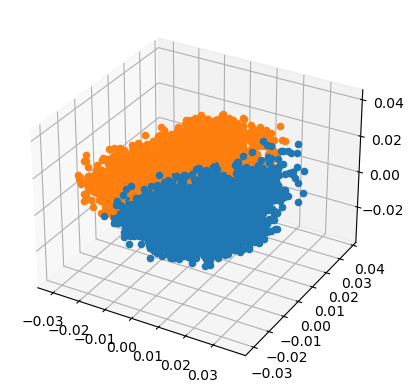

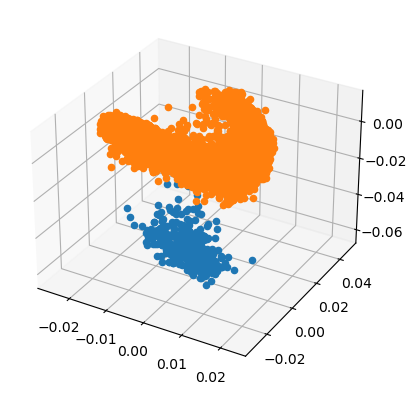

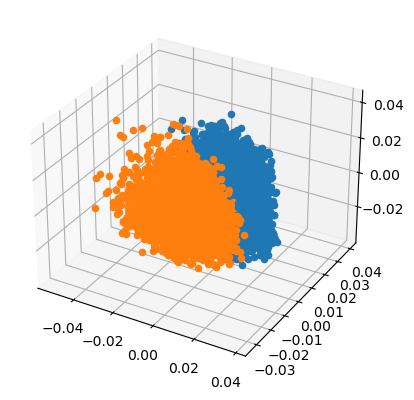

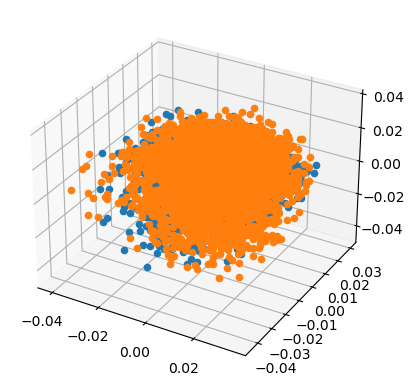

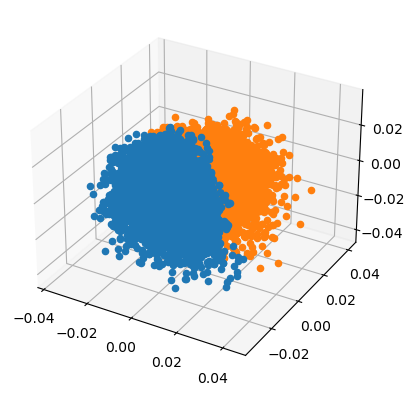

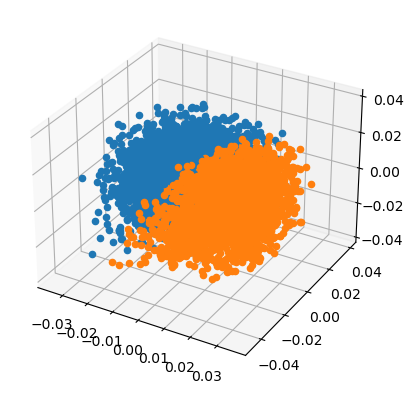

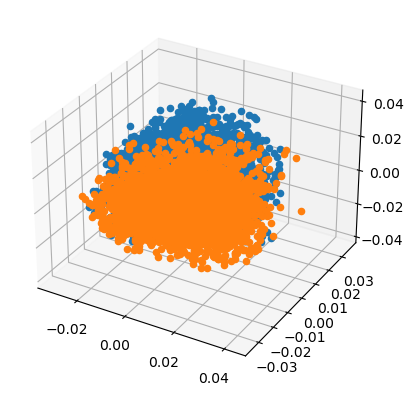

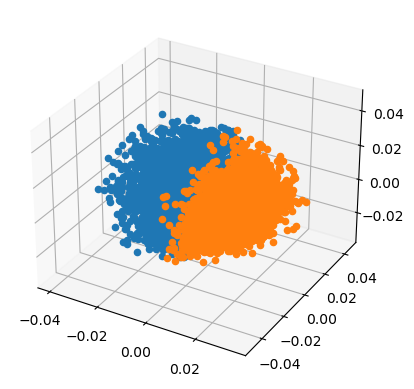

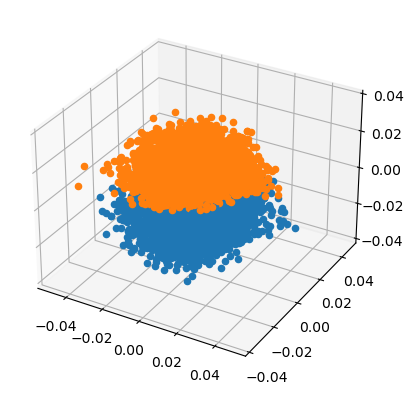

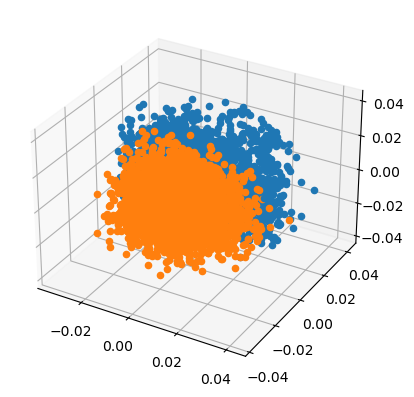

In [20]:
# # Show clusters for each class
# clusters_by_class, _ = naive_defence.cluster_activations()
# naive_defence.set_params(ndims=3)
#
# _, red_activations_by_class = naive_defence.cluster_activations()
# cs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
# for c in cs:
#     red_activations = red_activations_by_class[c]
#     clusters = clusters_by_class[c]
#     fig = plt.figure()
#     ax = plt.axes()
#     colors=["#0000FF", "#00FF00"]
#     for i, act in enumerate(red_activations):
#         ax.scatter(act[0], act[1], color = colors[clusters[i]])
naive_defence.plot_clusters()